## Load and predictions
Get the load that is going to be tested and its predictions

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
from tensorflow.keras.models import load_model

# get an absolute path to the directory that contains parent files
project_dir = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..")))

from barazmoon.twitter import twitter_workload_generator

from experiments.utils.constants import PROJECT_PATH, LSTM_PATH, LSTM_INPUT_SIZE

2023-04-16 00:19:46.637201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 00:19:46.818153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-16 00:19:46.818179: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-16 00:19:46.848094: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-16 00:19:47.445237: W tensorflow/stream_executor/pla

2023-04-16 00:19:49.318345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-16 00:19:49.318376: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-16 00:19:49.318422: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (microk8s-cluster-1): /proc/driver/nvidia/version does not exist
2023-04-16 00:19:49.318737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 4ms/step


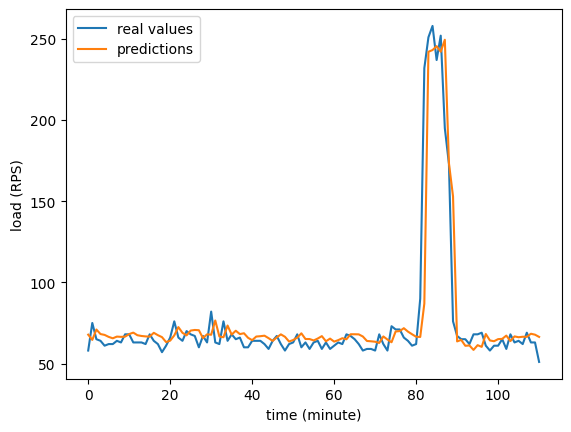

In [2]:
fig_path = os.path.join(PROJECT_PATH, "lstm-module", "lstm_prediction.png")

# TODO HERE fix in the easiest way

model = load_model(LSTM_PATH)
# workload = twitter_workload_generator('1-2')
workload = twitter_workload_generator("2:0:0:0-2:2:0:0")
workload = list(filter(lambda x: x != 0, workload))  # for removing missing hours
hour = 60 * 60
day = hour * 24
# test_idx = 18 * day
test_idx = 0
# test_data = workload[test_idx:test_idx + 2 * hour]
test_data = workload


def get_x_y(data):
    """
    For each 60 seconds it taeks the max of last 60 seconds
    and returns an output with length of len(data)/60 that
    each entry is the maximum rps in each aggregated 60 seconds
    x: series of max of every 1 minute
    y: target of the 10 minutes
    """
    x = []
    y = []
    history_seconds = 600
    for i in range(0, len(data) - history_seconds, 60):
        t = data[i : i + history_seconds]
        for j in range(0, len(t), 60):
            x.append(max(t[j : j + 60]))
        y.append(max(data[i + history_seconds : i + history_seconds + 60]))
    return x, y


test_x, test_y = get_x_y(test_data)

test_x = tf.convert_to_tensor(
    np.array(test_x).reshape((-1, LSTM_INPUT_SIZE, 1)), dtype=tf.float32
)
prediction = model.predict(test_x)
plt.plot(list(range(len(test_y))), list(test_y), label="real values")
plt.plot(list(range(len(test_y))), list(prediction), label="predictions")
plt.xlabel("time (minute)")
plt.ylabel("load (RPS)")
plt.legend()
plt.savefig(fig_path)

In [3]:
workload = twitter_workload_generator("1:0:0-1:2:0")
len(workload)

7201